In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
! pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.3 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv('/content/bert_tweets_130000.csv')
data.head()

,ID,text,sentiment,text_cleaned,text_len,labels,text_bert,text_len_bert
0,1629275091325583362,RT @PoliticalMoons2: These two recent articles...,0.18750,two recent articl discuss h5n1 bird flu detail...,14,1,"RT These two recent articles discuss H5N1 ""bir...",19
1,1629275094294884352,RT @hcasan0va: These people have lost their mi...,-0.15625,peopl lost mind bc there global org perspect d...,12,-1,RT These people have lost their minds. Just bc...,24
2,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks ...",0.00000,shed concern look like mrna transfer vaccin un...,11,0,"RT Shedding Concerns: ""It Looks Like the mRNA ...",20
3,1629275098308902912,"RT @VigilantFox: Ed Dowd: ""This Has Been a War...",0.10000,ed dowd war peopl die covid vaccin death earli...,12,1,"RT Ed Dowd: ""This Has Been a War"" ""The people ...",23
4,1629275098451509250,RT @porta_janet: @VigilantFox @DrKStillwagon T...,0.00000,vaccin brought covid covid brought vaccin,6,0,RT The vaccine was not brought in for Covid… C...,17


In [ ]:
data.labels = data.labels.astype(int)

In [ ]:
max_len=data['text_len_bert'][np.argmax(data.text_len_bert)]
max_len

66

In [ ]:
seed_value=42

X = data['text_bert'].values
y = data['labels'].values

In [ ]:
from tensorflow.keras.utils import to_categorical

one_hot_encode_y = to_categorical(y, num_classes=3)
print(one_hot_encode_y[:10])

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, one_hot_encode_y, test_size=0.2, stratify=one_hot_encode_y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)


In [ ]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Initialize bert layers

In [ ]:
# List of all the links

# BERT

preprocess_bert_base_uncased = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_bert_base_uncased =  "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

# ELECTRA

preprocess_electra_base_uncased ='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_electra_base_uncased = "https://tfhub.dev/google/electra_base/2"

# SMALL BERT

preprocess_smallbert_base_uncased ="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_smallbert_base_uncased = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2"

# ALBERT

preprocess_albert_base_uncased = "http://tfhub.dev/tensorflow/albert_en_preprocess/3"
encoder_albert_base_uncased =  "https://tfhub.dev/tensorflow/albert_en_base/3"

# ELECTRA SMALL

preprocess_smallelectra_base_uncased ='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_smallelectra_base_uncased = "https://tfhub.dev/google/electra_small/2"

# BERT BASE WIKIPEDIA AND BOOKSCORPUS

preprocess_wikibert_base_uncased = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_wikibert_base_uncased =  "https://tfhub.dev/google/experts/bert/wiki_books/2"


# BERT BASE UNCASED

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_bert_base_uncased, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_bert_base_uncased, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy',  "Precision", "Recall"])

In [ ]:
# Training saving the best model

from tensorflow.keras.callbacks import ModelCheckpoint

PATH_KERAS_BERT = '/content/BERTbase_model/'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_BERT,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = classifier_model.fit(x=X_train, y=y_train,
        batch_size=32, epochs=4,
        validation_data=(X_valid, y_valid),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/4
2221/2221 [==============================] - 2136s 941ms/step - loss: 0.2700 - accuracy: 0.8966 - precision: 0.9199 - recall: 0.8766 - val_loss: 0.1236 - val_accuracy: 0.9621 - val_precision: 0.9634 - val_recall: 0.9606
Epoch 2/4
2221/2221 [==============================] - 2111s 951ms/step - loss: 0.0784 - accuracy: 0.9753 - precision: 0.9771 - recall: 0.9737 - val_loss: 0.0803 - val_accuracy: 0.9748 - val_precision: 0.9757 - val_recall: 0.9741
Epoch 3/4
2221/2221 [==============================] - 2109s 950ms/step - loss: 0.0434 - accuracy: 0.9865 - precision: 0.9877 - recall: 0.9857 - val_loss: 0.0829 - val_accuracy: 0.9761 - val_precision: 0.9770 - val_recall: 0.9752
Epoch 4/4
2221/2221 [==============================] - 2103s 947ms/step - loss: 0.0272 - accuracy: 0.9913 - precision: 0.9919 - recall: 0.9909 - val_loss: 0.0943 - val_accuracy: 0.9760 - val_precision: 0.9773 - val_recall: 0.9752


In [ ]:
classifier_model.load_weights(PATH_KERAS_BERT)

In [ ]:
classifier_model.evaluate(X_test, y_test, verbose=2)

695/695 - 227s - loss: 0.0887 - accuracy: 0.9750 - precision: 0.9766 - recall: 0.9731 - 227s/epoch - 327ms/step


[0.08874830603599548,
 0.9749662280082703,
 0.9765939116477966,
 0.9731202125549316]

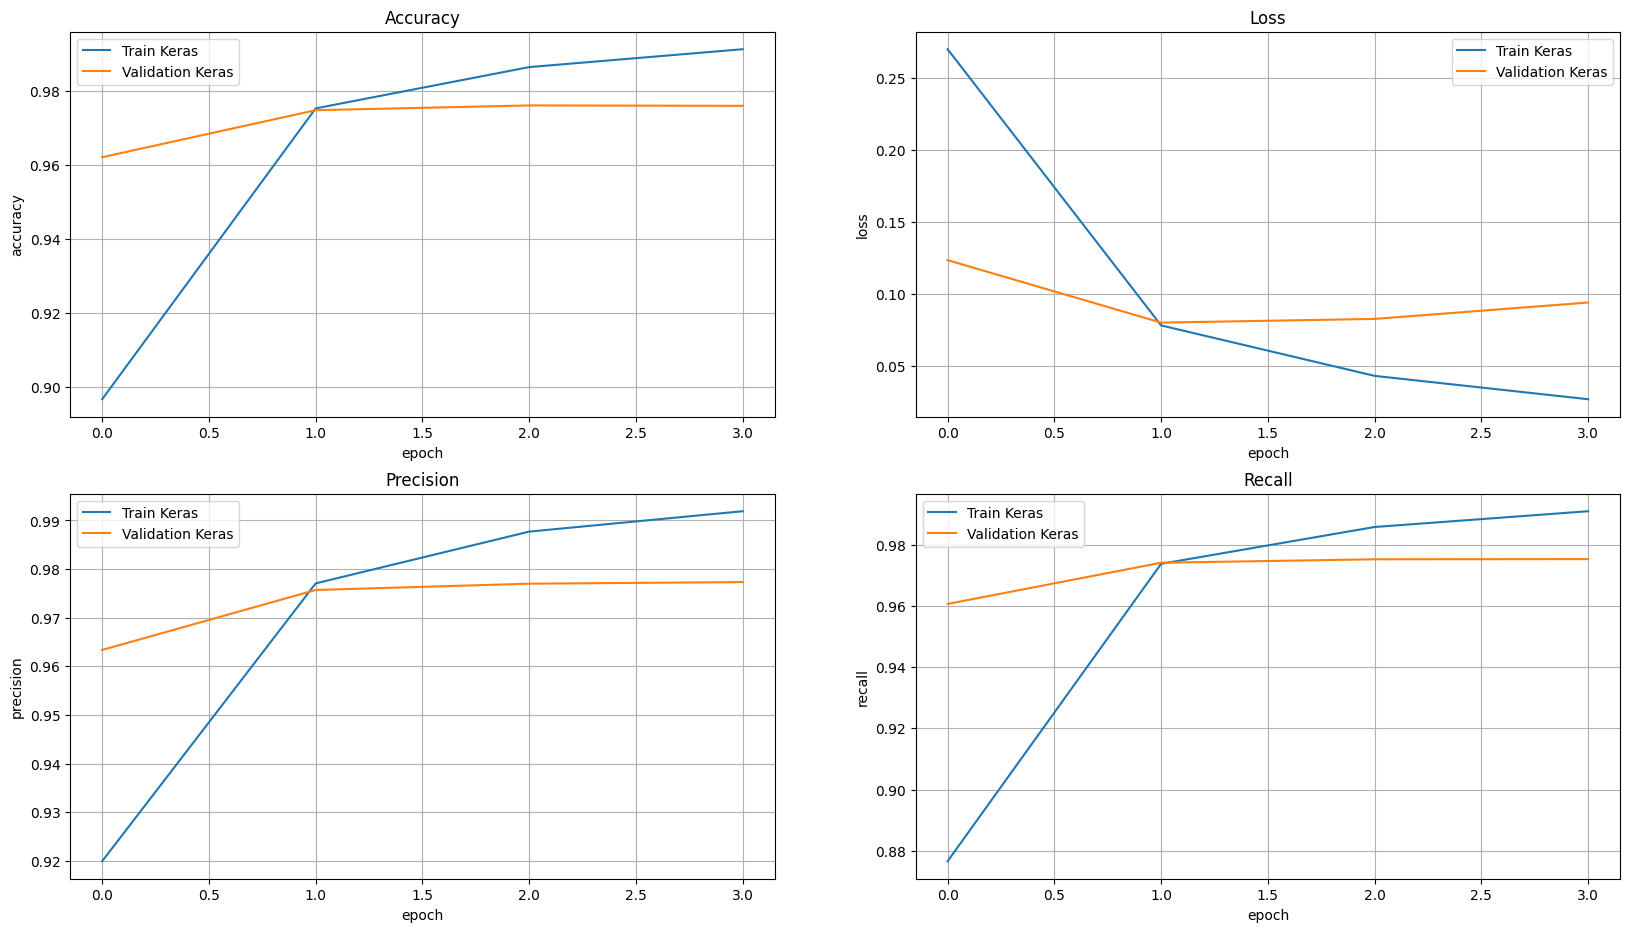

In [ ]:
# Visualize results of Keras model
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 11))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Keras')
plt.plot(history.history['val_precision'], label='Validation Keras')
plt.title("Precision")
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Keras')
plt.plot(history.history['val_recall'], label='Validation Keras')
plt.title("Recall")
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [ ]:
y_pred = classifier_model.predict(X_test)

695/695 [==============================] - 229s 329ms/step


In [ ]:
bert_pred = [np.argmax(pred) for pred in y_pred]
true_pred = [np.argmax(pred) for pred in y_test]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report for Bert Base Uncased:\n',classification_report(true_pred, bert_pred))

Classification Report for Bert Base Uncased:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      7206
           1       0.97      0.98      0.97      8557
           2       0.97      0.97      0.97      6447

    accuracy                           0.97     22210
   macro avg       0.98      0.97      0.97     22210
weighted avg       0.98      0.97      0.97     22210



In [ ]:
conf_bert = confusion_matrix(true_pred, bert_pred)
print(conf_bert)


[[7023  113   70]
 [  31 8407  119]
 [  46  177 6224]]


In [ ]:
conf_df_bert = pd.DataFrame(data=conf_bert, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'],
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<Axes: >

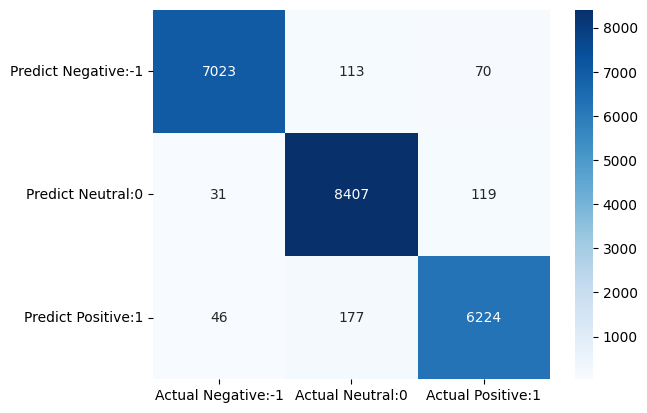

In [ ]:
import seaborn as sns

sns.heatmap(conf_df_bert, annot = True, fmt = '', cmap = 'Blues')

# ELECTRA

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_electra_base_uncased, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_electra_base_uncased, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy',  "Precision", "Recall"])

In [ ]:
# Training saving the best model

from tensorflow.keras.callbacks import ModelCheckpoint

PATH_KERAS_BERT = '/content/ELECTRAbasemodel/'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_BERT,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = classifier_model.fit(x=X_train, y=y_train,
        batch_size=32, epochs=4,
        validation_data=(X_valid, y_valid),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/4
2221/2221 [==============================] - 2204s 970ms/step - loss: 0.3384 - accuracy: 0.8685 - precision: 0.8971 - recall: 0.8416 - val_loss: 0.1360 - val_accuracy: 0.9561 - val_precision: 0.9593 - val_recall: 0.9531
Epoch 2/4
2221/2221 [==============================] - 2172s 978ms/step - loss: 0.1093 - accuracy: 0.9658 - precision: 0.9682 - recall: 0.9635 - val_loss: 0.1091 - val_accuracy: 0.9656 - val_precision: 0.9673 - val_recall: 0.9637
Epoch 3/4
2221/2221 [==============================] - 2172s 978ms/step - loss: 0.0632 - accuracy: 0.9806 - precision: 0.9822 - recall: 0.9795 - val_loss: 0.0945 - val_accuracy: 0.9725 - val_precision: 0.9735 - val_recall: 0.9720
Epoch 4/4
2221/2221 [==============================] - 2170s 977ms/step - loss: 0.0405 - accuracy: 0.9875 - precision: 0.9883 - recall: 0.9866 - val_loss: 0.1010 - val_accuracy: 0.9751 - val_precision: 0.9759 - val_recall: 0.9746


In [ ]:
classifier_model.load_weights(PATH_KERAS_BERT)

In [ ]:
classifier_model.evaluate(X_test, y_test, verbose=2)

695/695 - 226s - loss: 0.1061 - accuracy: 0.9746 - precision: 0.9754 - recall: 0.9739 - 226s/epoch - 325ms/step


[0.10606975853443146,
 0.9746060371398926,
 0.9753798842430115,
 0.9739306569099426]

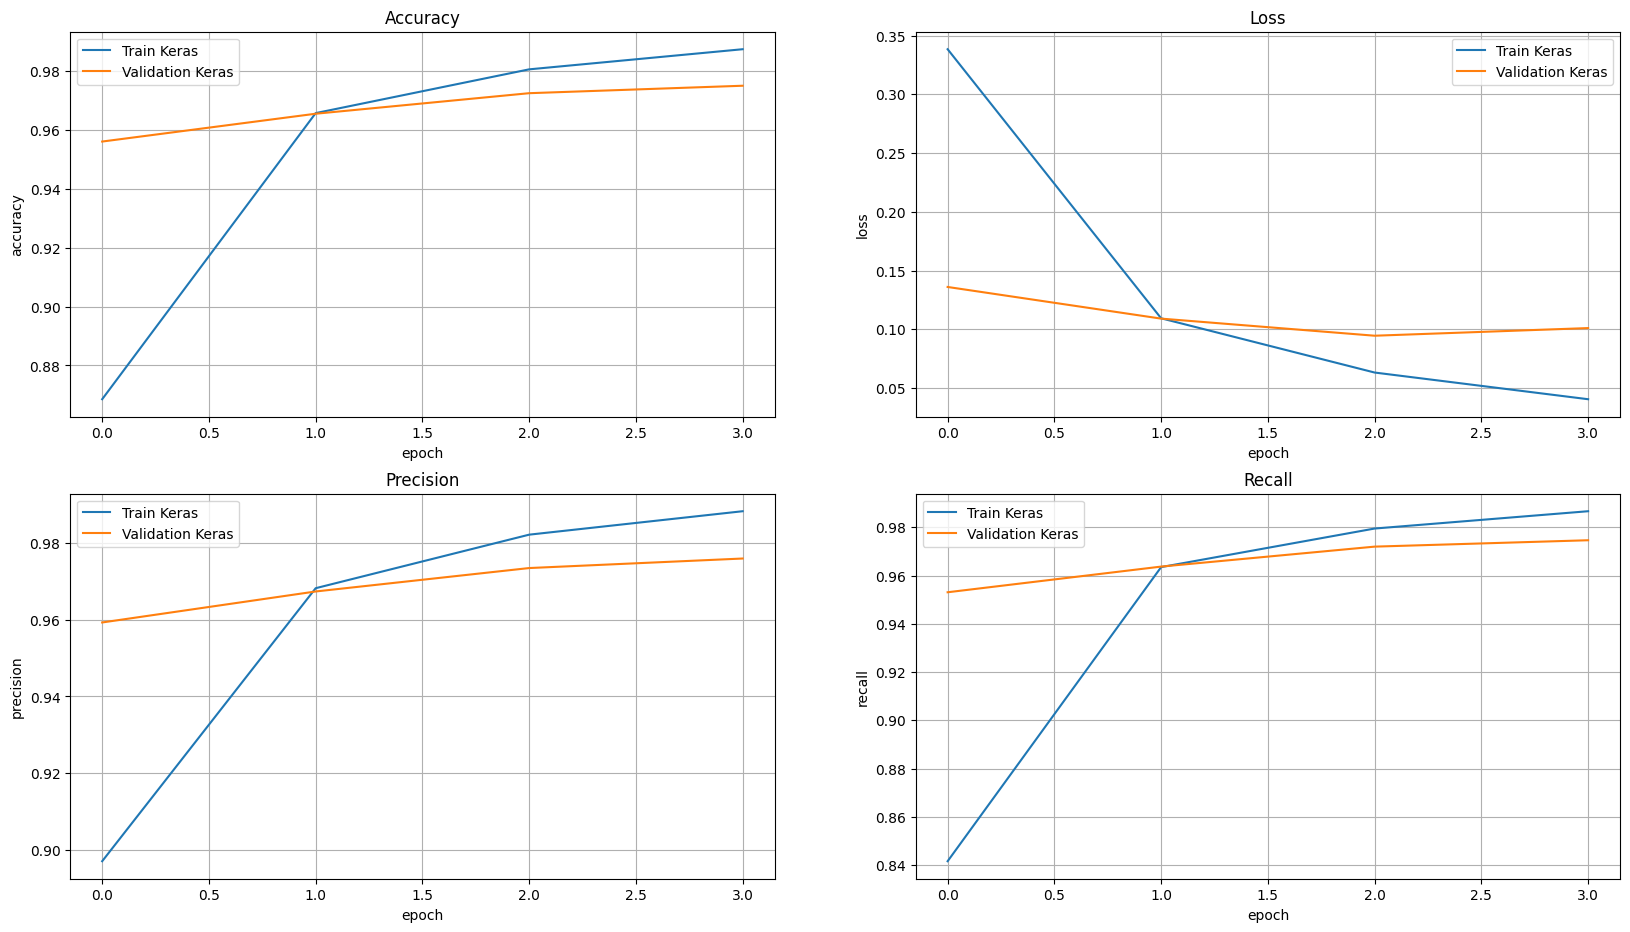

In [ ]:
# Visualize results of Keras model
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 11))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Keras')
plt.plot(history.history['val_precision'], label='Validation Keras')
plt.title("Precision")
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Keras')
plt.plot(history.history['val_recall'], label='Validation Keras')
plt.title("Recall")
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [ ]:
y_pred = classifier_model.predict(X_test)

695/695 [==============================] - 227s 326ms/step


In [ ]:
electra_pred = [np.argmax(pred) for pred in y_pred]
true_pred = [np.argmax(pred) for pred in y_test]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report for Bert Base Uncased:\n',classification_report(true_pred, electra_pred))

Classification Report for Bert Base Uncased:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      7206
           1       0.96      0.99      0.97      8557
           2       0.98      0.96      0.97      6447

    accuracy                           0.97     22210
   macro avg       0.98      0.97      0.97     22210
weighted avg       0.97      0.97      0.97     22210



In [ ]:
import sklearn.metrics

conf_bert = sklearn.metrics.confusion_matrix(true_pred, electra_pred)
print(conf_bert)


[[7048   91   67]
 [  40 8430   87]
 [  54  225 6168]]


In [ ]:
conf_df_bert = pd.DataFrame(data=conf_bert, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'],
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<Axes: >

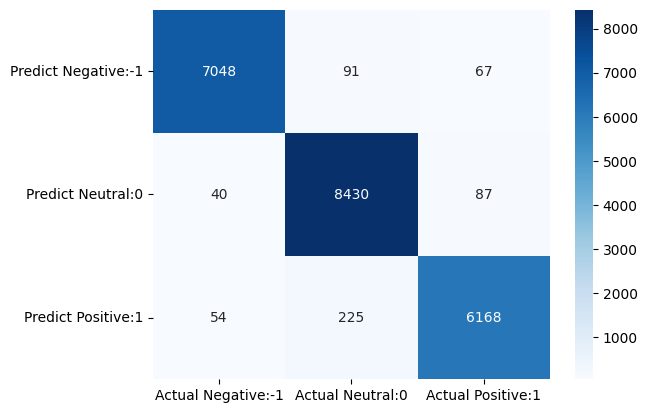

In [ ]:
import seaborn as sns

sns.heatmap(conf_df_bert, annot = True, fmt = '', cmap = 'Blues')


# SMALL BERT 

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_smallbert_base_uncased, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_smallbert_base_uncased, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy',  "Precision", "Recall"])

In [ ]:
# Training saving the best model

from tensorflow.keras.callbacks import ModelCheckpoint

PATH_KERAS_BERT = '/content/SMALLBERTbase_model/'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_BERT,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = classifier_model.fit(x=X_train, y=y_train,
        batch_size=32, epochs=4,
        validation_data=(X_valid, y_valid),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/4
2221/2221 [==============================] - 272s 118ms/step - loss: 0.6621 - accuracy: 0.7055 - precision: 0.7798 - recall: 0.6217 - val_loss: 0.3123 - val_accuracy: 0.8853 - val_precision: 0.8960 - val_recall: 0.8740
Epoch 2/4
2221/2221 [==============================] - 228s 102ms/step - loss: 0.3042 - accuracy: 0.8921 - precision: 0.9026 - recall: 0.8811 - val_loss: 0.2120 - val_accuracy: 0.9281 - val_precision: 0.9336 - val_recall: 0.9231
Epoch 3/4
2221/2221 [==============================] - 224s 101ms/step - loss: 0.2256 - accuracy: 0.9226 - precision: 0.9290 - recall: 0.9167 - val_loss: 0.1734 - val_accuracy: 0.9418 - val_precision: 0.9460 - val_recall: 0.9379
Epoch 4/4
2221/2221 [==============================] - 226s 102ms/step - loss: 0.1822 - accuracy: 0.9393 - precision: 0.9435 - recall: 0.9352 - val_loss: 0.1462 - val_accuracy: 0.9524 - val_precision: 0.9548 - val_recall: 0.9504


In [ ]:
classifier_model.load_weights(PATH_KERAS_BERT)

In [ ]:
classifier_model.evaluate(X_test, y_test, verbose=2)

695/695 - 45s - loss: 0.1486 - accuracy: 0.9522 - precision: 0.9549 - recall: 0.9502 - 45s/epoch - 65ms/step


[0.1486348807811737, 0.952183723449707, 0.9549321532249451, 0.9502025842666626]

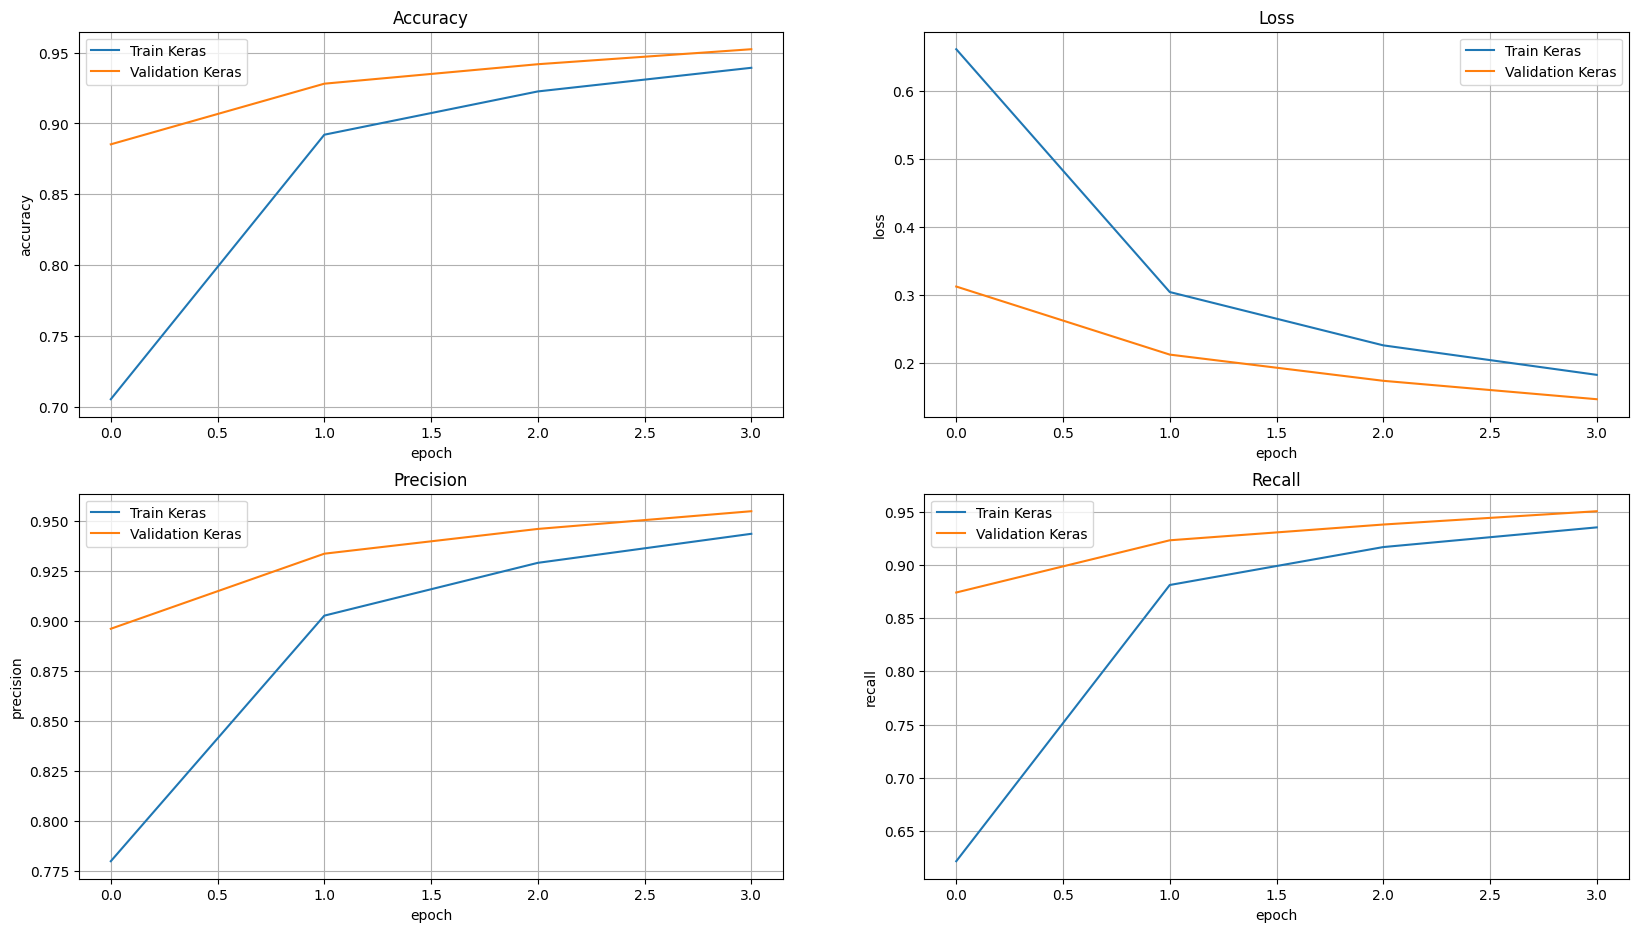

In [ ]:
# Visualize results of Keras model
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 11))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Keras')
plt.plot(history.history['val_precision'], label='Validation Keras')
plt.title("Precision")
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Keras')
plt.plot(history.history['val_recall'], label='Validation Keras')
plt.title("Recall")
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [ ]:
y_pred = classifier_model.predict(X_test)

695/695 [==============================] - 45s 64ms/step


In [ ]:
bert_pred = [np.argmax(pred) for pred in y_pred]
true_pred = [np.argmax(pred) for pred in y_test]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report for Bert Base Uncased:\n',classification_report(true_pred, bert_pred))

Classification Report for Bert Base Uncased:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      7206
           1       0.95      0.96      0.95      8557
           2       0.94      0.94      0.94      6447

    accuracy                           0.95     22210
   macro avg       0.95      0.95      0.95     22210
weighted avg       0.95      0.95      0.95     22210



In [ ]:
conf_bert = confusion_matrix(true_pred, bert_pred)
print(conf_bert)


[[6900  171  135]
 [  99 8184  274]
 [ 109  274 6064]]


In [ ]:
conf_df_bert = pd.DataFrame(data=conf_bert, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'],
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<Axes: >

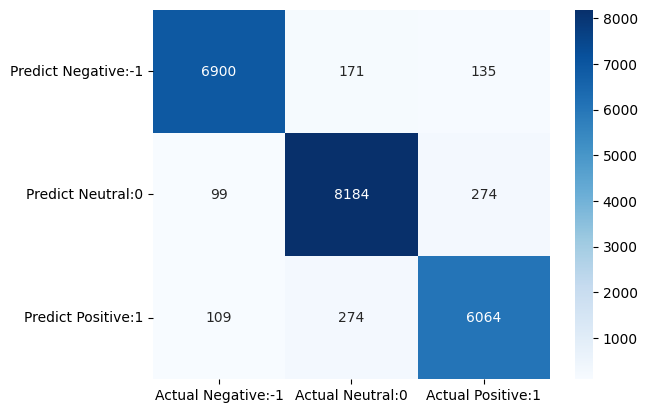

In [ ]:
import seaborn as sns

sns.heatmap(conf_df_bert, annot = True, fmt = '', cmap = 'Blues')

# SMALL ELECTRA

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_smallelectra_base_uncased, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_smallelectra_base_uncased, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy',  "Precision", "Recall"])

In [ ]:
# Training saving the best model

from tensorflow.keras.callbacks import ModelCheckpoint

PATH_KERAS_BERT = '/content/SmallElectrabase_model/'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_BERT,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = classifier_model.fit(x=X_train, y=y_train,
        batch_size=32, epochs=4,
        validation_data=(X_valid, y_valid),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/4
2221/2221 [==============================] - 851s 362ms/step - loss: 0.4191 - accuracy: 0.8299 - precision: 0.8687 - recall: 0.7953 - val_loss: 0.2012 - val_accuracy: 0.9341 - val_precision: 0.9388 - val_recall: 0.9303
Epoch 2/4
2221/2221 [==============================] - 805s 363ms/step - loss: 0.1588 - accuracy: 0.9477 - precision: 0.9518 - recall: 0.9439 - val_loss: 0.1271 - val_accuracy: 0.9578 - val_precision: 0.9599 - val_recall: 0.9558
Epoch 3/4
2155/2221 [============================>.] - ETA: 21s - loss: 0.1034 - accuracy: 0.9670 - precision: 0.9694 - recall: 0.9648

In [ ]:
classifier_model.load_weights(PATH_KERAS_BERT)

In [ ]:
classifier_model.evaluate(X_test, y_test, verbose=2)

In [ ]:
# Visualize results of Keras model
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 11))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Keras')
plt.plot(history.history['val_precision'], label='Validation Keras')
plt.title("Precision")
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Keras')
plt.plot(history.history['val_recall'], label='Validation Keras')
plt.title("Recall")
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [ ]:
y_pred = classifier_model.predict(X_test)

In [ ]:
bert_pred = [np.argmax(pred) for pred in y_pred]
true_pred = [np.argmax(pred) for pred in y_test]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report for Bert Base Uncased:\n',classification_report(true_pred, bert_pred))

In [ ]:
conf_bert = confusion_matrix(true_pred, bert_pred)
print(conf_bert)


In [ ]:
conf_df_bert = pd.DataFrame(data=conf_bert, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'],
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

In [ ]:
import seaborn as sns

sns.heatmap(conf_df_bert, annot = True, fmt = '', cmap = 'Blues')

# WIKI BERT 

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_wikibert_base_uncased, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_wikibert_base_uncased, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy',  "Precision", "Recall"])

In [ ]:
# Training saving the best model

from tensorflow.keras.callbacks import ModelCheckpoint

PATH_KERAS_BERT = '/content/WIKIBERTbase_model/'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_BERT,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = classifier_model.fit(x=X_train, y=y_train,
        batch_size=32, epochs=4,
        validation_data=(X_valid, y_valid),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/4
2221/2221 [==============================] - 2210s 975ms/step - loss: 0.6089 - accuracy: 0.7267 - precision: 0.7952 - recall: 0.6587 - val_loss: 0.2657 - val_accuracy: 0.9052 - val_precision: 0.9134 - val_recall: 0.8987
Epoch 2/4
2221/2221 [==============================] - 2182s 982ms/step - loss: 0.2117 - accuracy: 0.9269 - precision: 0.9339 - recall: 0.9197 - val_loss: 0.1891 - val_accuracy: 0.9366 - val_precision: 0.9419 - val_recall: 0.9322
Epoch 3/4
2221/2221 [==============================] - 2188s 985ms/step - loss: 0.1313 - accuracy: 0.9556 - precision: 0.9588 - recall: 0.9526 - val_loss: 0.1328 - val_accuracy: 0.9567 - val_precision: 0.9597 - val_recall: 0.9549
Epoch 4/4
2221/2221 [==============================] - 2184s 983ms/step - loss: 0.0865 - accuracy: 0.9712 - precision: 0.9730 - recall: 0.9696 - val_loss: 0.1087 - val_accuracy: 0.9693 - val_precision: 0.9702 - val_recall: 0.9688


In [ ]:
classifier_model.load_weights(PATH_KERAS_BERT)

In [ ]:
classifier_model.evaluate(X_test, y_test, verbose=2)

695/695 - 236s - loss: 0.1093 - accuracy: 0.9705 - precision: 0.9716 - recall: 0.9699 - 236s/epoch - 340ms/step


[0.10928677767515182,
 0.9705087542533875,
 0.9715858101844788,
 0.9699234366416931]

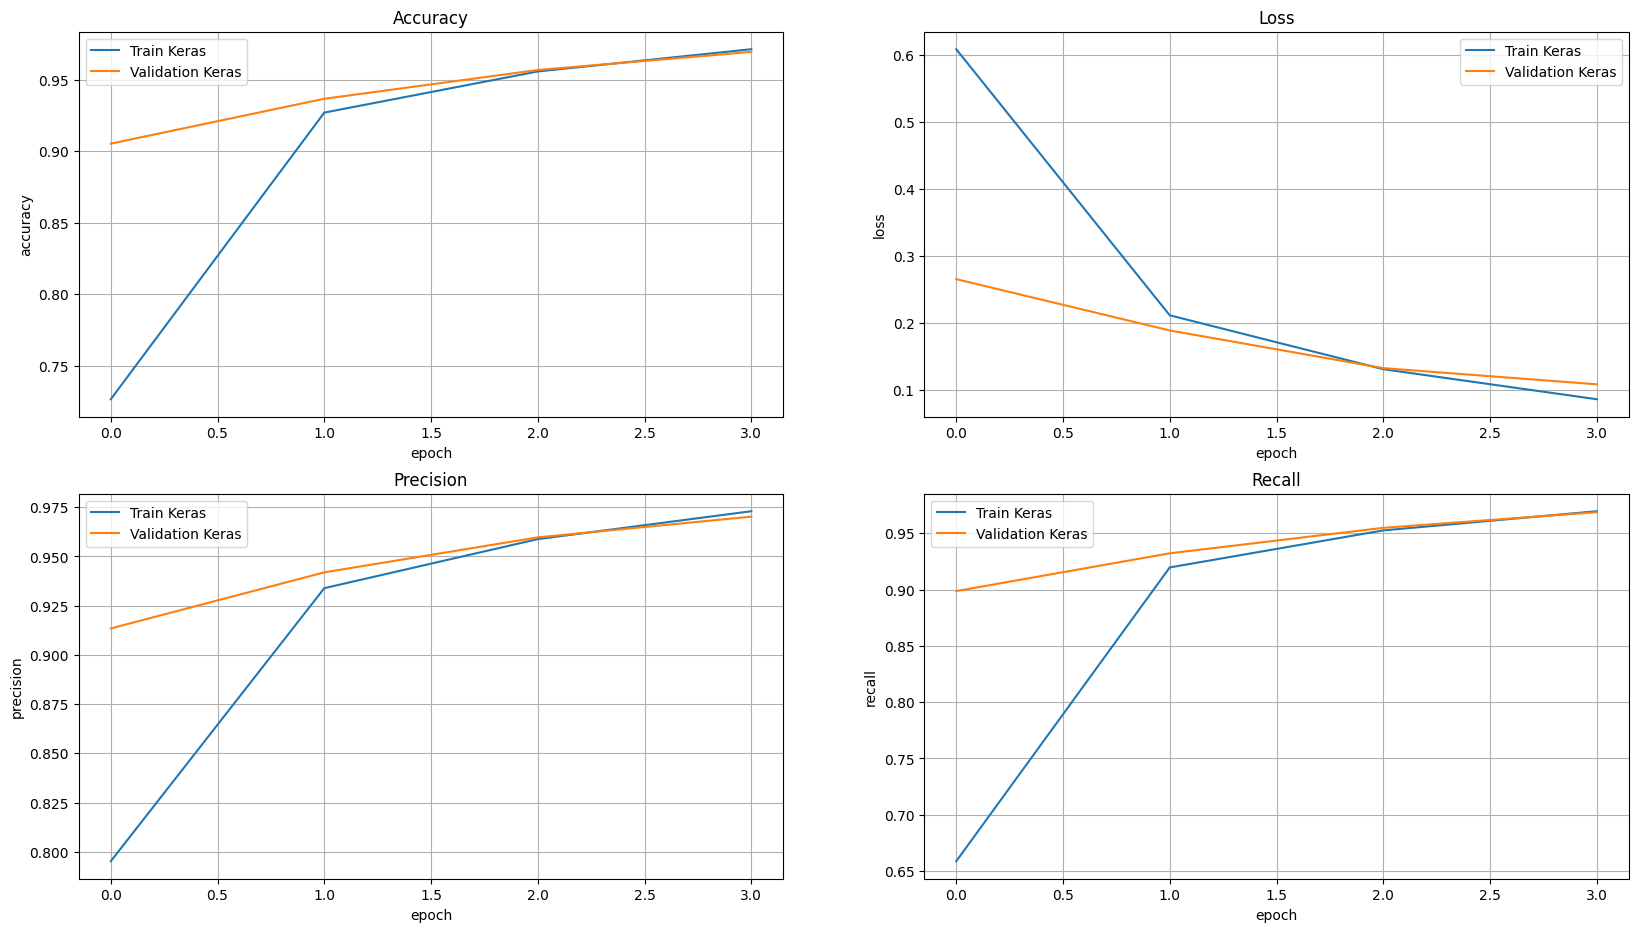

In [ ]:
# Visualize results of Keras model
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 11))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Keras')
plt.plot(history.history['val_precision'], label='Validation Keras')
plt.title("Precision")
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Keras')
plt.plot(history.history['val_recall'], label='Validation Keras')
plt.title("Recall")
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [ ]:
y_pred = classifier_model.predict(X_test)

695/695 [==============================] - 236s 339ms/step


In [ ]:
bert_pred = [np.argmax(pred) for pred in y_pred]
true_pred = [np.argmax(pred) for pred in y_test]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report for Bert Base Uncased:\n',classification_report(true_pred, bert_pred))

Classification Report for Bert Base Uncased:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      7206
           1       0.97      0.97      0.97      8557
           2       0.96      0.96      0.96      6447

    accuracy                           0.97     22210
   macro avg       0.97      0.97      0.97     22210
weighted avg       0.97      0.97      0.97     22210



In [ ]:
conf_bert = confusion_matrix(true_pred, bert_pred)
print(conf_bert)


[[7073   67   66]
 [  67 8279  211]
 [  86  158 6203]]


In [ ]:
conf_df_bert = pd.DataFrame(data=conf_bert, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'],
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<Axes: >

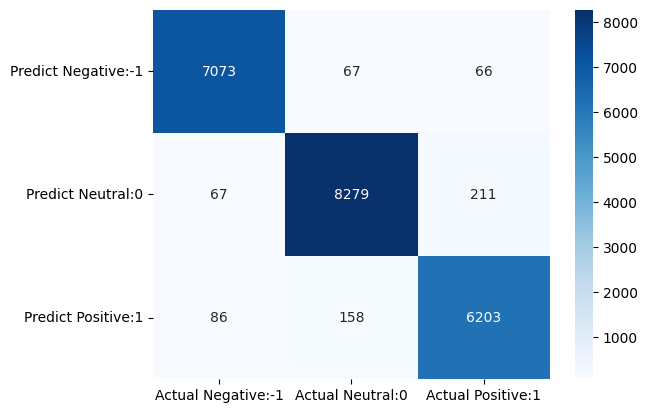

In [ ]:
import seaborn as sns

sns.heatmap(conf_df_bert, annot = True, fmt = '', cmap = 'Blues')

# ALBERT

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_albert_base_uncased, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_albert_base_uncased, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy',  "Precision", "Recall"])

In [ ]:
# Training saving the best model

from tensorflow.keras.callbacks import ModelCheckpoint

PATH_KERAS_BERT = '/content/Albertbase_model/'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_BERT,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = classifier_model.fit(x=X_train, y=y_train,
        batch_size=32, epochs=8,
        validation_data=(X_valid, y_valid),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/8
141/141 [==============================] - 165s 1s/step - loss: 0.9724 - accuracy: 0.5190 - precision: 0.6069 - recall: 0.3580 - val_loss: 0.7158 - val_accuracy: 0.6840 - val_precision: 0.7590 - val_recall: 0.5920
Epoch 2/8
141/141 [==============================] - 158s 1s/step - loss: 0.6455 - accuracy: 0.7203 - precision: 0.7760 - recall: 0.6664 - val_loss: 0.6231 - val_accuracy: 0.7580 - val_precision: 0.7868 - val_recall: 0.7160
Epoch 3/8
141/141 [==============================] - 158s 1s/step - loss: 0.4429 - accuracy: 0.8277 - precision: 0.8549 - recall: 0.8019 - val_loss: 0.4621 - val_accuracy: 0.8300 - val_precision: 0.8337 - val_recall: 0.8120
Epoch 4/8
141/141 [==============================] - 159s 1s/step - loss: 0.2209 - accuracy: 0.9195 - precision: 0.9282 - recall: 0.9117 - val_loss: 0.4495 - val_accuracy: 0.8420 - val_precision: 0.8554 - val_recall: 0.8280
Epoch 5/8
141/141 [==============================] - 158s 1s/step - loss: 0.1019 - accuracy: 0.9678 - pr

In [ ]:
classifier_model.load_weights(PATH_KERAS_BERT)

In [ ]:
classifier_model.evaluate(X_test, y_test, verbose=2)

18/18 - 6s - loss: 0.7098 - accuracy: 0.8345 - precision: 0.8370 - recall: 0.8309 - 6s/epoch - 310ms/step


[0.7097880244255066,
 0.8345323801040649,
 0.8369565010070801,
 0.8309352397918701]

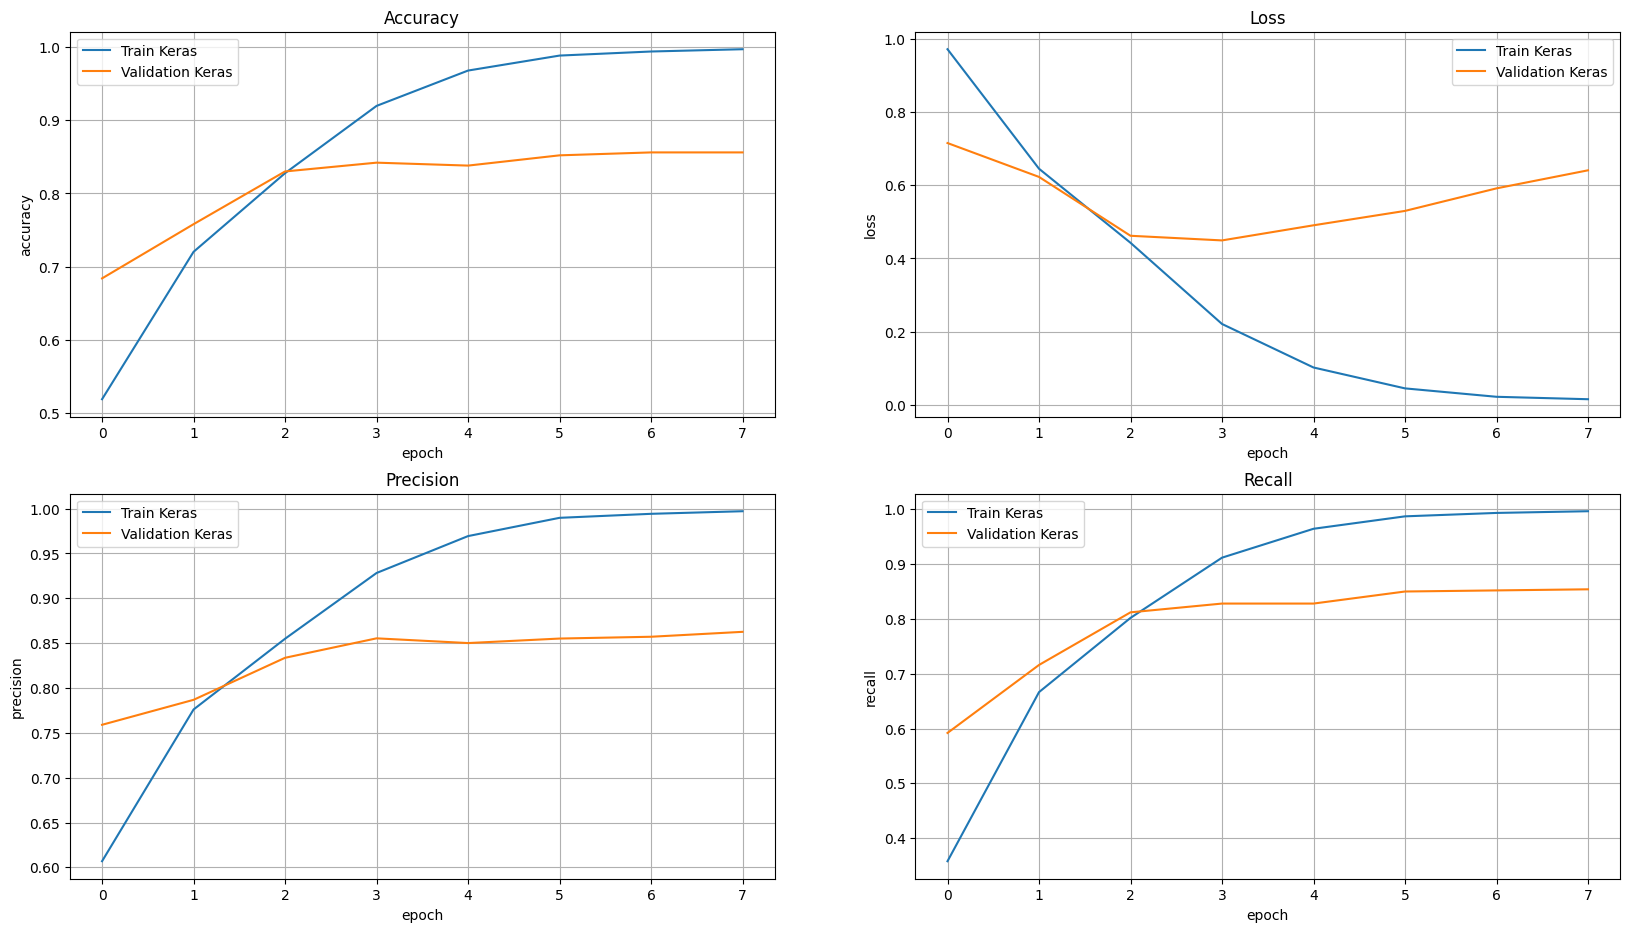

In [ ]:
# Visualize results of Keras model
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 11))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Keras')
plt.plot(history.history['val_precision'], label='Validation Keras')
plt.title("Precision")
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Keras')
plt.plot(history.history['val_recall'], label='Validation Keras')
plt.title("Recall")
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [ ]:
y_pred = classifier_model.predict(X_test)

18/18 [==============================] - 8s 395ms/step


In [ ]:
albert_pred = [np.argmax(pred) for pred in y_pred]
true_pred = [np.argmax(pred) for pred in y_test]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report for Bert Base Uncased:\n',classification_report(true_pred, albert_pred))

Classification Report for Bert Base Uncased:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84       181
           1       0.86      0.84      0.85       214
           2       0.91      0.72      0.81       161

    accuracy                           0.83       556
   macro avg       0.85      0.83      0.83       556
weighted avg       0.84      0.83      0.83       556



In [ ]:
conf_bert = confusion_matrix(true_pred, bert_pred)
print(conf_bert)


[[153  15  13]
 [ 10 185  19]
 [ 15  19 127]]


In [ ]:
conf_df_bert = pd.DataFrame(data=conf_bert, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'],
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<Axes: >

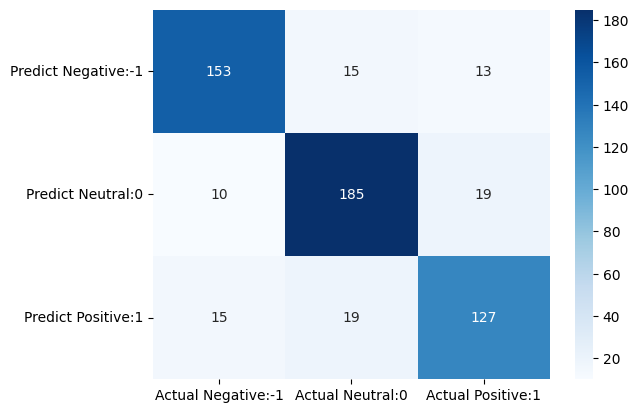

In [ ]:
import seaborn as sns

sns.heatmap(conf_df_bert, annot = True, fmt = '', cmap = 'Blues')